## House Prices: Advanced Regression Techniques


### About the challenge

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.


Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting

Dataset documentation - http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

### About this notebook

This notebook is structured in the following manner:
  

Data Preprocessing:
  
  - handle target feature values;
  - perform feature engineering: some transformations will be performed on merged train and test datasets and others separately to avoid data leakage;
  - handle outliers;
  - add new features and drop uninformative ones
  
Modelling:
  
  - check baseline models
  - apply stack modelling
  - take a weighted sum of predictions
  - attaining and evaluate the final result
  

### About the results

The final predictions, produced by the blended model scored 0.18324, which corresponds to top 5% on the public leaderboard. 

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, cross_val_score

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#### Load Data

- Load the data as train and test datasets
- Save ID column for the later submission and drop it from data

In [131]:
# Read files
train = pd.read_csv('train_house_prices.csv')
test = pd.read_csv('test_house_prices.csv')

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# From EDA obvious outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

outliers = [30, 88, 462, 631, 1322]
train = train.drop(train.index[outliers])


#print (train.columns)
#print(test.columns)
print(train.shape,test.shape)

(1453, 80) (1459, 79)


In [132]:
#train.describe()

In [133]:
#train.head(7)

### Data preprocessing

#### Handling the target feature values

Comparing the distribution of the target feature values - SalePrice - to the normal dictribution, it becomes clear that it is heavily skewed. To meet one of the linear regression assumptions (normality of the error distribution) we will apply log transform at this step.

Note: the final predictions have then to be transformed back exponentially to represent the actual prices of the houses, instead of their logs.

Log(x+1) transformation will pe applied. More on that:

http://onbiostatistics.blogspot.com/2012/05/logx1-data-transformation.html


 mu = 181268.63 and sigma = 79370.09



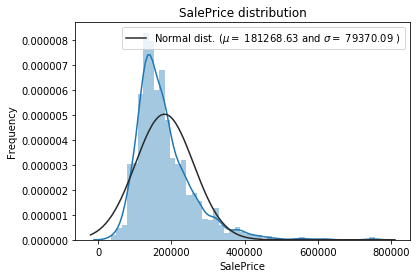

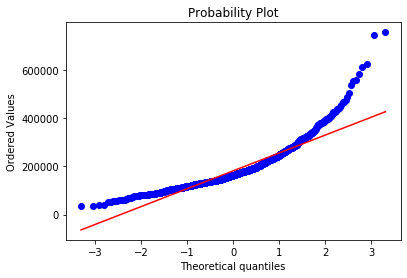

In [134]:
sns.distplot(train['SalePrice'] , fit=norm)
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.03 and sigma = 0.40



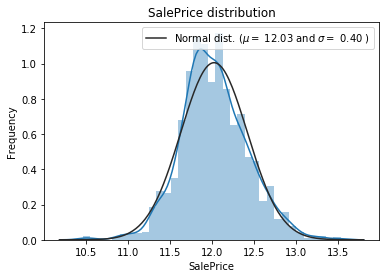

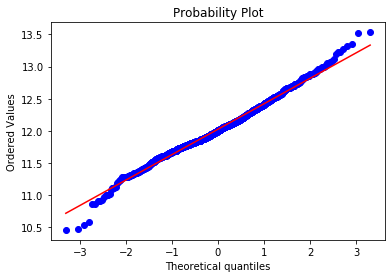

In [135]:
y_train_original = train["SalePrice"]
train["SalePrice"] = np.log1p(train["SalePrice"])

sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

#### Preparing data for the further manipulations

In [136]:
y_train = train["SalePrice"]
X_train = train.drop('SalePrice', axis = 1)
X_test = test
ntrain = train.shape[0]
ntest = test.shape[0]

#### Preforming imputing: Handling missing values, categorical features, skeawed features.

At this point a number of functions for the feture engeniring process will be defined.

First, a function to calculate and plot the ratio of missing values in a datasat will be implemented. 

Then, a function to perform transformations of separete datasets will be defined. These include imputing missing values with aggregated values (mode) and handling skewed values.  

Lastly, a function will be defined, to replace missing values with none and 0, as well as turning categorical features into string. These transformations can be performed on both datasets, withouth running into a risk of data leakage.

In [137]:
def missing_values_ratio(data):
    data_na = (data.isnull().sum() / len(data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return  data_na, missing_data


def plot_missing_values_ratio(data):
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x=data.index, y=data, palette = "PRGn")
    
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)

    

def imputing_on_separate_sets(dataset, columns_na_mode):
    
    for column in columns_na_mode:
        dataset.fillna(dataset[column].mode()[0], inplace=True)
    
    numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index
    skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
 
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    # skewness.head(10)
    

    skewness = skewness[abs(skewness.Skew)>0.75]
    #print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

    
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        dataset[feat] = boxcox1p(dataset[feat], lam)

    dataset[skewed_features] = np.log1p(dataset[skewed_features])    

    
def imputing_on_both_sets(dataset, columns_na_none, columns_na_0,
                          columns_to_string):
    
    for column in columns_na_none:
        dataset[column].fillna('None', inplace=True)
    
    
    for column in columns_na_0:
        dataset[column].fillna(0, inplace=True)
    
   # dataset.drop(columns_to_be_dropped, axis=1, inplace=True)

    for column in columns_to_string:
        dataset[column] = dataset[column].apply(str)

    return dataset

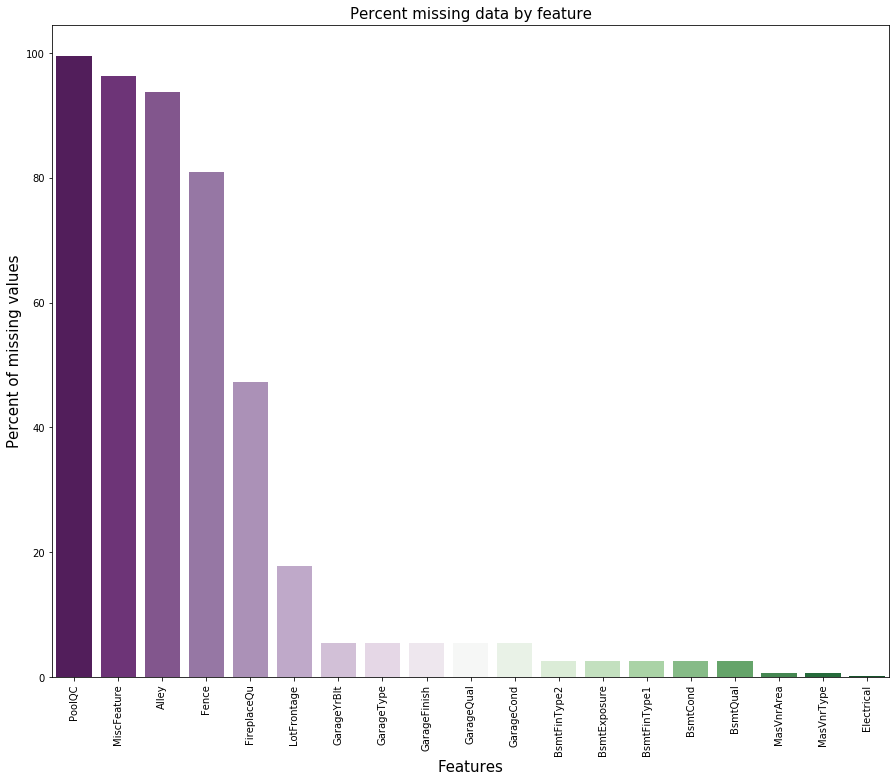

In [138]:
missing_data, missing_data_df = missing_values_ratio(X_train)
missing_data_df
plot_missing_values_ratio(missing_data)

In [139]:
columns_to_none = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
           ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']
columns_to_string = ['MSSubClass','YrSold','MoSold']
columns_na_mode = ['LotFrontage', 'Neighborhood','Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual', 'MSZoning']
columns_to_0 = ['GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
           ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF']

# data description says NA means typical
X_train['Functional'] = X_train['Functional'].fillna('Typ')
X_test['Functional'] = X_test['Functional'].fillna('Typ')

In [140]:
imputing_on_separate_sets(X_train, columns_na_mode)

In [141]:
imputing_on_separate_sets(X_test, columns_na_mode)

In [142]:
both_datasets = pd.concat((X_train, X_test)).reset_index(drop=True)

In [143]:
imputing_on_both_sets(both_datasets, columns_na_none = columns_to_none,
                     columns_na_0 = columns_to_0,
                     columns_to_string =columns_to_string)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.8997924093002385,RL,1.921519,3.006286,Pave,60,Reg,Lvl,AllPub,Inside,...,0.0,0.0,60,60,60,0.000000,2,2008,WD,Normal
1,1.580792865271824,RL,1.977023,3.030723,Pave,60,Reg,Lvl,AllPub,FR2,...,0.0,0.0,60,60,60,0.000000,5,2007,WD,Normal
2,1.8997924093002385,RL,1.933684,3.060922,Pave,60,IR1,Lvl,AllPub,Inside,...,0.0,0.0,60,60,60,0.000000,9,2008,WD,Normal
3,1.941468956599639,RL,1.899792,3.029726,Pave,60,IR1,Lvl,AllPub,Corner,...,0.0,0.0,60,60,60,0.000000,2,2006,WD,Abnorml
4,1.8997924093002385,RL,1.989891,3.105714,Pave,60,IR1,Lvl,AllPub,FR2,...,0.0,0.0,60,60,60,0.000000,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,2.1540916118775932,RM,1.595848,2.713464,Pave,60,Reg,Lvl,AllPub,Inside,...,0.0,0.0,60,60,60,0.000000,6,2006,WD,Normal
2908,2.1540916118775932,RM,1.595848,2.708937,Pave,60,Reg,Lvl,AllPub,Inside,...,0.0,0.0,60,60,60,0.000000,4,2006,WD,Abnorml
2909,1.580792865271824,RL,2.154092,3.168931,Pave,60,Reg,Lvl,AllPub,Inside,...,0.0,0.0,60,60,60,0.000000,9,2006,WD,Abnorml
2910,1.9930021912229312,RL,1.908716,3.046737,Pave,60,Reg,Lvl,AllPub,Inside,...,0.0,0.0,60,MnPrv,Shed,2.497127,7,2006,WD,Normal


#### Adding features

Some features can be merged into one without loosing the informativeness. For instance, instead of having four different features representing the number of bathrooms in a property, one feature holding this information can be created. 

In [144]:
#  Total sqfootage feature 
both_datasets['TotalSF']=both_datasets['TotalBsmtSF'] + both_datasets['1stFlrSF'] + both_datasets['2ndFlrSF']

#  Total bathrooms feature
both_datasets['Total_Bathrooms'] = (both_datasets['FullBath'] + (0.5 * both_datasets['HalfBath']) +
                               both_datasets['BsmtFullBath'] + (0.5 * both_datasets['BsmtHalfBath']))
#  Total porch sqfootage feature
both_datasets['Total_porch_sf'] = (both_datasets['OpenPorchSF'] + both_datasets['3SsnPorch'] +
                              both_datasets['EnclosedPorch'] + both_datasets['ScreenPorch'] +
                              both_datasets['WoodDeckSF'])

Other features can be represented in a binary mode. For example, instead of having the actual area of a pool, a feature will be created, to indicate whether a property does have a pool or a garage.

In [145]:
both_datasets['haspool'] = both_datasets['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
both_datasets['hasgarage'] = both_datasets['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
both_datasets['hasbsmt'] = both_datasets['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
both_datasets['hasfireplace'] = both_datasets['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


# Not normaly distributed can not be normalised and has no central tendecy
both_datasets = both_datasets.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1)

print('data_features size:', both_datasets.shape)

data_features size: (2912, 81)


####  Final transformations

Lastly, dummy variables will be created to encode categorial features. The merged dataset will then be split back into train and test sets.

In [146]:
both_datasets_final = pd.get_dummies(both_datasets)

print(both_datasets_final.shape)

(2912, 341)


In [147]:
X_train = both_datasets_final[:ntrain]
X_test = both_datasets_final[ntrain:]

In [148]:
X_train.shape

(1453, 341)

In [149]:
X_test.shape

(1459, 341)

#### Modelling

Before precedeeing with choosing and training models, a loss function will be defined. For this project the root mean square error is chosen and will be implemented with the CrossValidation. A kfolds parameter for the CrossValidation will be also set at this step. 

In [150]:
kfolds = KFold(n_splits=18, shuffle=True, random_state=42)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

Checking the baseline

In [151]:
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression

Lasso Regression will be picked as the first baseline model regarding a considerable number of features and feture selection that can be performe by the Lasso algorithm.

In [152]:
baseline_regressor = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
baseline_regressor.score(X_train, y_train)

0.7431380360089724

In [153]:
rmse(y_train, baseline_regressor.predict(X_train))

0.20111833384815522

A number of further more advanced single learners will be defined, trained and validated in the next step. 

In [154]:
import xgboost

In [155]:
xgboost = xgboost.XGBRegressor()
xgboost.fit(X_train, y_train)

[14:48:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [156]:
rmse(y_train, xgboost.predict(X_train))

0.08008278924887093

This solution looks much better. Now a RandomizedGridDearch will be appplied to find more optimal hyperparameters.

In [157]:
params_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 1.5],
        'subsample': [0.6, 0.8, 1.0],
        'eta': [0.001, 0.01, 0.1],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

clf_xgb = RandomizedSearchCV(xgboost, params_xgb, random_state=0)
search = clf_xgb.fit(X_train, y_train)


[14:48:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [158]:
search.best_params_

{'subsample': 1.0,
 'min_child_weight': 10,
 'max_depth': 5,
 'gamma': 0,
 'eta': 0.001,
 'colsample_bytree': 1.0}

In [159]:
xgboost_after_gs = XGBRegressor(subsample = 1.0,
     min_child_weight = 10,
     max_depth = 5,
     gamma = 0,
     eta = 0.001,
     colsample_bytree =  1.0
    )

In [160]:
xgboost_after_gs.fit(X_train, y_train)
rmse(y_train, xgboost_after_gs.predict(X_train))

[14:50:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.06521500368749572

In [161]:
lightgbm = LGBMRegressor(objective='regression', 
                         bagging_seed=7,
                        feature_fraction_seed=7,
                        verbose=-1,
)

lightgbm.fit(X_train, y_train)
rmse(y_train, lightgbm.predict(X_train))

0.03991968068456023

In [162]:
params_lgbm = {
        'num_leaves': [3, 4, 5, 6], 
        'learning_rate': [0.001, 0.01, 0.1], 
        'n_estimators' : [5000, 7000, 8000, 9000],
        'max_bin' : [100, 200, 300],
        'bagging_fraction': [0.25, 0.5, 0.75],
        'bagging_freq': [3, 5, 7],
        'feature_fraction': [0.2, 0.3, 0.5, 0.7],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

clf_lgbm = RandomizedSearchCV(lightgbm, params_lgbm, random_state=0)
search = clf_lgbm.fit(X_train, y_train)
search.best_params_

{'num_leaves': 4,
 'n_estimators': 7000,
 'max_depth': 5,
 'max_bin': 300,
 'learning_rate': 0.01,
 'feature_fraction': 0.5,
 'colsample_bytree': 0.6,
 'bagging_freq': 7,
 'bagging_fraction': 0.75}

In [163]:
lightgbm_after_gs = LGBMRegressor(objective='regression', 
                                       num_leaves=4, 
                                       learning_rate=0.01, 
                                       n_estimators=9000, 
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1
                            )

In [164]:
lightgbm_after_gs.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2, feature_fraction_seed=7,
              importance_type='split', learning_rate=0.01, max_bin=200,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=9000, n_jobs=-1, num_leaves=4,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [165]:
rmse(y_train, lightgbm_after_gs.predict(X_train))

0.058715980499043106

Few further regressors will be defined in the next cell using pipelines and RobustScaler to deal with the outliers. These will be then trained and scored iteratively. An extended metric (now including cross validation) will be added.

In [166]:
def cv_rmse(model, X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [167]:
alphas_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]



ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_ridge, cv=kfolds))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas_lasso,random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))


stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, lightgbm),
                                meta_regressor=elasticnet,
                                use_features_in_secondary=True)

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

models = {'xgboost': xgboost_after_gs,
          'lightgbm': lightgbm, 
          'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'lightgbm': lightgbm_after_gs,
          'Svd': svr,
          'stack_gen' :stack_gen 
         } 
        
predictions = {}
scores = {}

In [ ]:
for name, model in models.items():
    
    model.fit(X_train, y_train)
    predictions[name] = np.expm1(model.predict(X_train))
    
    score = cv_rmse(model, X_train)
    scores[name] = (score.mean(), score.std())

In [169]:
scores

{'xgboost': (0.11280715587330585, 0.01392388237966856),
 'lightgbm': (0.10516313245879672, 0.017251653754298133),
 'Ridge': (0.10318434147827252, 0.0158418781150881),
 'Lasso': (0.1015273083520324, 0.01669997909871342),
 'ElasticNet': (0.10143848633619729, 0.016641271357214753),
 'Svd': (0.10215710736109737, 0.017144881429090306)}

#### Blended model

In [170]:
def blend_models_predict(X):
    return (
        (0.16  * elasticnet.predict(X)) + 
        (0.16 * lasso.predict(X)) + 
        (0.11 * ridge.predict(X)) + 
        (0.2 * lightgbm_after_gs.predict(X)) + 
        (0.1 * svr.predict(X)) + 
        (0.27 * stack_gen.predict(np.array(X))))

#   Eliminating xfboost model from the blended model resulted 
#   in a significant improvement of the preformance of the model.        
#   (0.1 * xgboost_after_gs.predict(X))

In [171]:
print('RMSE score on train data:')
print(rmse(y_train, blend_models_predict(X_train)))

RMSE score on train data:
0.07977967973459947


In [ ]:
predictions = np.expm1(blend_models_predict(X_test))

In [ ]:
def make_submission(test_ID, predictions, learner_name):
    submission = pd.DataFrame(data={'Id': test_ID, 'SalePrice': predictions})
    #results = pd.merge(test_ID, predictions, left_index=True, right_index=True)
    submission.to_csv(path_or_buf = 'house_prices_%s.csv' % learner_name, header = True, index = False)     

In [ ]:
make_submission(test_ID, predictions, 'blended_models_exp')